In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import math

from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
from matplotlib.lines import Line2D
from collections import Counter
from datetime import datetime

seed = 265
torch.manual_seed(seed)

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cpu.


In [362]:
# ----------------------- Setup ----------------------------
PATH_GENERATED = './generated/'

vocab = torch.load(PATH_GENERATED + 'vocabulary.pt', map_location=torch.device(device))
embedding = torch.load(PATH_GENERATED + 'embedding.pt', map_location=torch.device(device))
(VOCAB_SIZE, embedding_dim) = embedding.weight.shape  

words_train = torch.load(PATH_GENERATED + "words_train.pt", map_location=torch.device(device))
words_val   = torch.load(PATH_GENERATED + "words_val.pt", map_location=torch.device(device))
words_test  = torch.load(PATH_GENERATED + "words_test.pt", map_location=torch.device(device))

In [363]:
CONTEXT_SIZE = 10
conjugation_list = ['be', 'am', 'are', 'is', 'was', 'were', 'been', 'being', 'have', 'has', 'had', 'having']
MAP_TARGET = {vocab[w]:i for i, w in enumerate(conjugation_list)}

def create_dataset(text, vocab, context_size=CONTEXT_SIZE, map_target=MAP_TARGET):
    
    # Transform each word to its index in the vocabulary.
    txt = [vocab[w] for w in text]

    n_text = len(text)
    context_center = int(context_size/2)

    contexts = []
    targets = []
    for i in range(n_text - context_center):
        
        t = txt[i + context_center]
        if  not vocab.lookup_token(t) in conjugation_list: continue # We only want to guess conjunctions of be and have.
        c = txt[i:i + context_center] + txt[i + context_center +1:i + context_size+1]
        
        targets.append(map_target[t]) 
        contexts.append(torch.tensor(c).to(device=device))
            
    contexts = torch.stack(contexts)
    targets = torch.tensor(targets).to(device=device)
    return TensorDataset(contexts, targets)

In [364]:
def load_dataset(words, vocab, fname):
    """
    Load dataset if already generated, otherwise, create it and save it
    """
    
    if os.path.isfile(PATH_GENERATED + fname):
        dataset = torch.load(PATH_GENERATED + fname, map_location=torch.device(device))
    else:
        dataset = create_dataset(words, vocab)
        torch.save(dataset, PATH_GENERATED + fname)
    return dataset

data_train_conj = load_dataset(words_train, vocab, "conj_data_train.pt")
data_val_conj   = load_dataset(words_val, vocab, "conj_data_val.pt")
data_test_conj  = load_dataset(words_test, vocab, "conj_data_test.pt")

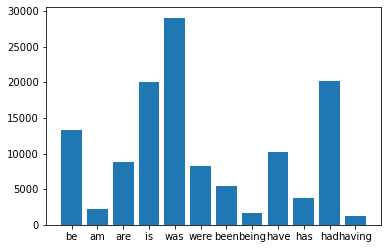

In [366]:
counts = Counter(data_train_conj[:][1].tolist())
values = [int(counts[i]) for i in range(len(counts))]
plt.bar(conjugation_list, values)
plt.show()

The distribution of the target words are very skewed, we need to weigh the words by their frequency in the training set

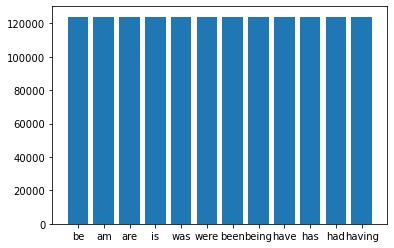

In [367]:
def calculate_word_weights(values):
    """
    Calculate the weight of each word so that the loss function can weigh 
    frequent words less and unfrequent words more.
    """
    total_words = sum(values)
    word_weights = [total_words / value for value in values]
    word_weights = torch.tensor(word_weights, dtype=torch.float).to(device=device)
    return word_weights

word_weigts = calculate_word_weights(values)
values_balanced = [int(values[i])*w for i, w in enumerate(word_weigts)]
plt.bar(conjugation_list, values_balanced)
plt.show()

In [368]:
# ---------------- Attention functions -----------------------
pos_encoding = torch.zeros((CONTEXT_SIZE, embedding_dim))
for i in range(CONTEXT_SIZE):
    for ii in range(int(embedding_dim/2)):
        pos_encoding[i][2*ii] = math.sin(i/1000**((2*ii)/embedding_dim))
        pos_encoding[i][2*ii +1] = math.cos(i/1000**((2*ii)/embedding_dim))

In [369]:
# ---------------- Simple MLP hyper parameters -----------------------
lrs = [0.1, 0.01, 0.001]
decays = [0.8, 0.5, 0.1]
mlp_hparams = [{
    'lr': lr,
    'weight_decay': decay
} for lr in lrs for decay in decays]

# ---------------- Attention MLP hyper parameters ----------------------- 
lrs = [0.1, 0.01, 0.001]
attention_hparams = [{
    'lr': lr,
} for lr in lrs]

# ---------------- RNN MLP hyper parameters ----------------------- 
lrs = [0.1, 0.01, 0.001]
rnn_hparams = [{
    'lr': lr,
} for lr in lrs]


train_loader = DataLoader(data_test_conj, batch_size=128, shuffle=True)
val_loader = DataLoader(data_val_conj, batch_size=128, shuffle=True)
test_loader = DataLoader(data_test_conj, batch_size=128, shuffle=True)

In [370]:
# ---------------- Train and accuracy -----------------------
def train(n_epochs, optimizer, model, loss_fn, train_loader):

    n_batch = len(train_loader)
    losses_train = []
    model.train()
    optimizer.zero_grad(set_to_none=True)

    for epoch in range(1, n_epochs + 1):

        loss_train = 0.0
        for contexts, targets in train_loader:

            contexts = contexts.to(device=device)
            targets = targets.to(device=device)

            outputs = model(contexts)

            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()

        losses_train.append(loss_train / n_batch)

        if epoch == 1 or epoch % 5 == 0:
            print('{}  |  Epoch {}  |  Training loss {:.5f}'.format(
                datetime.now().time(), epoch, loss_train / n_batch))
    return losses_train

def compute_accuracy(model, loader):
    """
    Computes accuracy as correctly predicted / total 
    """
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for contexts, targets in loader:
            contexts = contexts.to(device=device)
            targets = targets.to(device=device)

            outputs = model(contexts)
            _, predicted = torch.max(outputs, dim=1)
            total += len(targets)
            correct += int((predicted == targets).sum())

    acc =  correct / total
    return acc

In [371]:
class SimpleMLP(nn.Module):
    def __init__(self, embedding, context_size=CONTEXT_SIZE):
        super().__init__()

        (vocab_size, embedding_dim) = embedding.weight.shape
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.load_state_dict(embedding.state_dict())
        for p in self.embedding.parameters():
            p.requires_grad = False

        self.fc1 = nn.Linear(embedding_dim*context_size, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 12)

    def forward(self, x):
        out = self.embedding(x)
        out = F.relu(self.fc1(torch.flatten(out, 1)))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)

        return out

class AttentionMLP(nn.Module):
    def __init__(self, n_heads=5):
        super().__init__()

        self.n_heads = n_heads
        self.embedding = nn.Embedding(VOCAB_SIZE, embedding_dim)
        self.embedding.load_state_dict(embedding.state_dict())
        for p in self.embedding.parameters():
            p.requires_grad = False

        self.W_q = nn.Parameter(torch.rand((self.n_heads, CONTEXT_SIZE, embedding_dim)))
        self.W_k = nn.Parameter(torch.rand((self.n_heads, CONTEXT_SIZE, embedding_dim)))
        self.W_v = nn.Parameter(torch.rand((self.n_heads, CONTEXT_SIZE, embedding_dim)))
        self.W_o = nn.Parameter(torch.rand((embedding_dim, self.n_heads * CONTEXT_SIZE)))

        self.fc1 = nn.Linear(embedding_dim*CONTEXT_SIZE, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 12)
    
    def forward(self, x):
        batch_size, _ = x.size()
        x = self.embedding(x)
        x = x + pos_encoding
        
        multi_attn_heads = []
        for ii in range(CONTEXT_SIZE):
            attn_heads = torch.empty(0)
            for i in range(self.n_heads):
                q = x[:,ii,:] @ self.W_q[i].T
                k = x[:,ii,:] @ self.W_k[i].T 
                v = x[:,ii,:] @ self.W_v[i].T
                
                attn_weights = torch.stack([q[j] @ k[j].T for j in range(batch_size) ])
                attn_weights = torch.softmax(attn_weights / math.sqrt(CONTEXT_SIZE), dim=-1)
                attn_head = torch.unsqueeze(attn_weights, dim=1) * v
                attn_heads = torch.cat((attn_heads, attn_head), 1)
            multi_attn_heads.append(self.W_o @ attn_heads.T)
       
        multi_attn_heads = torch.stack(multi_attn_heads)
        out = multi_attn_heads.permute(2, 0, 1)
        out = F.relu(self.fc1(torch.flatten(out, 1)))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out
    
class RNN(nn.Module):
    def __init__(self, embedding):
        super().__init__()

        self.embedding = nn.Embedding(VOCAB_SIZE, embedding_dim)
        self.embedding.load_state_dict(embedding.state_dict())
        for p in self.embedding.parameters():
            p.requires_grad = False

        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=12, batch_first=True, bidirectional=True)

    def forward(self, x):
        x = self.embedding(x)
        out, (h_n, c_n) = self.lstm(x)
        return h_n[-1]
        

In [372]:
def train_models():
    
    train_losses = []
    models = []
    accuracies = []
    params = []

    print("Now training a simple MLP model")
    for param in mlp_hparams:
        print(f"Training using parameters: {param}")
        torch.manual_seed(seed)
        model = SimpleMLP(embedding)
        loss_fn = nn.CrossEntropyLoss(weight=word_weigts)
        optimizer = optim.Adam(model.parameters(), **param)
        n_epochs = 10
        
        loss = train(n_epochs, optimizer, model, loss_fn, train_loader)
        accuracy = compute_accuracy(model, val_loader)

        models.append(model)
        train_losses.append(loss)
        accuracies.append(accuracy)
        params.append(param)
        print()

    print("Now training a MLP model with attention")
    for param in attention_hparams:
        print(f"Training using parameters: {param}")
        torch.manual_seed(seed)
        model = AttentionMLP(embedding)
        loss_fn = nn.CrossEntropyLoss(weight=word_weigts)
        optimizer = optim.Adam(model.parameters(), **param)
        n_epochs = 10
        
        loss = train(n_epochs, optimizer, model, loss_fn, train_loader)
        accuracy = compute_accuracy(model, val_loader)

        models.append(model)
        train_losses.append(loss)
        accuracies.append(accuracy)
        params.append(param)
        print()
    
    print("Now training a RNN model")
    for param in rnn_hparams:
        print(f"Training using parameters: {param}")
        torch.manual_seed(seed)
        model = RNN(embedding)
        loss_fn = nn.CrossEntropyLoss(weight=word_weigts)
        optimizer = optim.Adam(model.parameters(), **param)
        n_epochs = 10
        
        loss = train(n_epochs, optimizer, model, loss_fn, train_loader)
        accuracy = compute_accuracy(model, val_loader)

        models.append(model)
        train_losses.append(loss)
        accuracies.append(accuracy)
        params.append(param)
        print()
        
    return models, params, train_losses, accuracies

models, params, train_losses, accuracies = train_models()

Now training a simple MLP model
Training using parameters: {'lr': 0.1, 'weight_decay': 0.8}
10:48:53.554794  |  Epoch 1  |  Training loss 2.48242
10:48:53.850528  |  Epoch 5  |  Training loss 2.48157
10:48:54.225317  |  Epoch 10  |  Training loss 2.48127

Training using parameters: {'lr': 0.1, 'weight_decay': 0.5}
10:48:54.355124  |  Epoch 1  |  Training loss 2.48167
10:48:54.648536  |  Epoch 5  |  Training loss 2.47955
10:48:55.005686  |  Epoch 10  |  Training loss 2.48043

Training using parameters: {'lr': 0.1, 'weight_decay': 0.1}
10:48:55.092904  |  Epoch 1  |  Training loss 2.48453
10:48:55.403768  |  Epoch 5  |  Training loss 2.47133
10:48:55.823088  |  Epoch 10  |  Training loss 2.47901

Training using parameters: {'lr': 0.01, 'weight_decay': 0.8}
10:48:56.008042  |  Epoch 1  |  Training loss 2.48140
10:48:56.376624  |  Epoch 5  |  Training loss 2.48080
10:48:56.796271  |  Epoch 10  |  Training loss 2.48142

Training using parameters: {'lr': 0.01, 'weight_decay': 0.5}
10:48:56.9

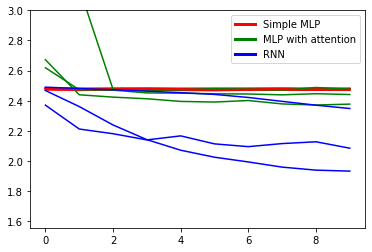

In [373]:
for i, loss in enumerate(train_losses):
    if i < 9:
        plt.plot(loss, "r-", label="Simple MLP")
    elif i < 12:
        plt.plot(loss, "g-", label="MLP with attention")
    else:
        plt.plot(loss, "b-", label="RNN")

colors = ['r', 'g', 'b']
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
labels = ["Simple MLP", "MLP with attention", "RNN"]
plt.legend(lines, labels)
plt.ylim(top=3)
plt.show()

In [374]:
best_idx = accuracies.index(max(accuracies))
best_model = models[best_idx]
best_param = params[best_idx]
print(f"The best performing model is {best_model} with an accuracy of {accuracies[best_idx]}")

The best performing model is RNN(
  (embedding): Embedding(1880, 16)
  (lstm): LSTM(16, 12, batch_first=True, bidirectional=True)
) with an accuracy of 0.2617760617760618


In [375]:
train_val_loader = DataLoader(ConcatDataset([data_train_conj, data_val_conj]), batch_size=128, shuffle=True)
print(f"Retraining best model for longer on train + val dataset")
loss_fn = nn.CrossEntropyLoss(weight=word_weigts)
optimizer = optim.Adam(best_model.parameters(), **best_param)
n_epochs = 50

best_model_loss = train(n_epochs, optimizer, best_model, loss_fn, train_val_loader)
accuracy = compute_accuracy(best_model, test_loader)

Retraining best model for longer on train + val dataset
10:53:28.167939  |  Epoch 1  |  Training loss 1.87689
10:53:50.327213  |  Epoch 5  |  Training loss 1.71567
10:54:17.365983  |  Epoch 10  |  Training loss 1.68251
10:54:44.973305  |  Epoch 15  |  Training loss 1.68121
10:55:13.457773  |  Epoch 20  |  Training loss 1.69082
10:55:46.489169  |  Epoch 25  |  Training loss 1.66523
10:56:20.548881  |  Epoch 30  |  Training loss 1.67317
10:56:53.936480  |  Epoch 35  |  Training loss 1.71163
10:57:27.670970  |  Epoch 40  |  Training loss 1.68033
10:58:00.624279  |  Epoch 45  |  Training loss 1.66157
10:58:35.011688  |  Epoch 50  |  Training loss 1.66929


The accuracy of the best model on the test set was 0.35299055613851


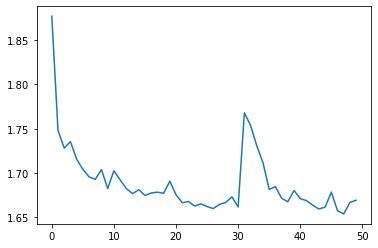

In [376]:
plt.plot(best_model_loss)
print(f"The accuracy of the best model on the test set was {accuracy}")